<a href="https://colab.research.google.com/github/young1ll/time-series-da/blob/main/notebook/BTCUSD_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Cryptocurrency Price With Tensorflow and Keras

- python v3.11.0

## References
- https://medium.com/@huangkh19951228/predicting-cryptocurrency-price-with-tensorflow-and-keras-e1674b0dc58a
- https://github.com/khuangaf/CryptocurrencyPrediction/tree/master

#### getting started(from git repo)
1. [Test] Daily

In [ ]:
# # 해당 경로 제거
# import shutil
# shutil.rmtree('/content/weights_2018to2023')

### 데이터 수집
- JSONtoCSV
- csv를 바로 직접 사용한다면 아래 과정 pass

In [81]:
import json
import numpy as np
import os
import pandas as pd
# import urllib2
import urllib.request

# connect to poloniex's API
# url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1356998100&end=9999999999&period=300'

# parse json returned from the API to Pandas DF
# openUrl = urllib.request.urlopen(url)
# r = openUrl.read()
# openUrl.close()
# d = json.loads(r.decode())
# df = pd.DataFrame(d)

# original_columns=[u'close', u'date', u'high', u'low', u'open']
# new_columns = ['Close','Timestamp','High','Low','Open']
# df = df.loc[:,original_columns]
# df.columns = new_columns
# df.to_csv('data/bitcoin2015to2017.csv',index=None)

### 전처리

### PastSampler
> 데이터 스케일링

In [1]:
import numpy as np
import pandas as pd
 
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        이전 샘플 N으로 K특징 샘플 예측
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #row 당 샘플 수(sample + target)
        #indexes
        I = np.arange(M) + np.arange(0, A.shape[0] - M + self.sliding_window, M).reshape(-1, 1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #샘플 당 특징 수
        return B[:, :ci], B[:, ci:] #샘플 매트릭스, 대상 매트릭스

#data file path
# dfp = 'data/bitcoin2015to2017.csv'
# dfp = 'data/Bitstamp_BTCUSD_1h.csv' # 2018-05-15 to 2023-05-08
dfp = '../data/2012to2023_BTC-USD.csv' # 2018-05-15 to 2023-05-08
# [unix, date, symbol, open, high, low, close, Volume BTC, Volume USD]

#Columns of price data to use
columns = ['Price']
df = pd.read_csv(dfp)
time_stamps = df['Date']
df = df.loc[:,columns]
original_df = pd.read_csv(dfp).loc[:,columns]

FileNotFoundError: [Errno 2] No such file or directory: '../data/2012to2023_BTC-USD.csv'

In [2]:
df

NameError: name 'df' is not defined

> 경우에 따라 `Price`와 같은 가격 데이터가 string 값으로 저장되어 있는 경우가 있다. 이는 exel에서 csv를 읽거나, exel에서 csv를 읽는 등의 경우에 의해 **소수점 이후의 일부 값이 자동으로 반올림 되는 상황**을 방지하기 위해 float을 string으로 저장한 경우에 해당한다.

> Preprocessing: string to double

In [191]:
# time_stamps = pd.to_datetime(time_stamps, format="%b %d, %Y")

In [192]:
time_stamps

0       May 08, 2023
1       May 07, 2023
2       May 06, 2023
3       May 05, 2023
4       May 04, 2023
            ...     
4043    Apr 12, 2012
4044    Apr 11, 2012
4045    Apr 10, 2012
4046    Apr 09, 2012
4047    Apr 08, 2012
Name: Date, Length: 4048, dtype: object

In [193]:
df['Price'] = df['Price'].str.replace(',', '').astype(float)

In [194]:
df.dtypes

Price    float64
dtype: object

#### H5 사용하기
아래는 PastSampler를 통해 `.csv`데이터를 `h5`데이터로 변환하는 과정이다.
- `h5`로 저장하면 모델을 학습시키는 도중에 문제가 발생하더라도 중단 지점부터 다시 시작할 수 있다.
- 

In [195]:
# file_name='bitcoin2015to2017_close.h5'
file_name='bitcoin2012to2023_close.h5'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization: 하나씩
for c in columns:
  df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

# normalization: 전체
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [196]:
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps)[:,None,None]
#Make samples of temporal sequences of pricing data (channel)
# NPS, NFS = 24, 1  #Number of past and future samples: 24시간으로 1시간 예측
NPS, NFS = 8, 1
ps = PastSampler(NPS, NFS, sliding_window=True)
B, Y = ps.transform(A)
input_times, output_times = ps.transform(time_stamps)
original_B, original_Y = ps.transform(original_A)

In [197]:
import h5py
with h5py.File(file_name, 'w') as f:
    f.create_dataset("inputs", data = B)
    f.create_dataset('outputs', data = Y)
    f.create_dataset("input_times", data = input_times)
    f.create_dataset('output_times', data = output_times)
    f.create_dataset("original_datas", data=np.array(original_df))
    f.create_dataset('original_inputs',data=original_B)
    f.create_dataset('original_outputs',data=original_Y)

In [198]:
B.shape

(449, 8, 1)

---
### Building Models

#### 1. CNN(Conv1D)
> 에러메시지: \
> ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

위 에러메시지는 `batch_size`를 매개변수로 초기화 하지 않았거나, Conv 데이터 모양이 일치하지 않아 발생하는 문제.

**해결**: api를 사용하지 않고 2018년도부터 2023년까지 1시간 단위 데이터가 있는 csv를 바로 사용(기존 api는 기간 제한이 있었음.)

> _Output Time Steps = (Input Time Steps - Kernel Size) / Strides + 1_

In [199]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from imageio import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt
plt.switch_backend('agg')
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'True'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

with h5py.File(''.join(['bitcoin2012to2023_close.h5']), 'r') as hf:
    datas = hf['inputs'][()]
    labels = hf['outputs'][()]
    input_times = hf['input_times'][()]
    output_times = hf['output_times'][()]
    original_datas = hf['original_datas'][()]
    original_outputs = hf['original_outputs'][()]

In [200]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:]
ground_true = original_outputs[training_size:,:]

In [201]:
step_size = datas.shape[1]
batch_size= 16
nb_features = datas.shape[2]
epochs = 100

In [202]:
# model.add(Conv1D(filters=2, padding='same', kernel_size=8, activation='relu', input_shape=(step_size, nb_features)))
# model.add(Conv1D(filters=2, padding='same', kernel_size=8, activation='relu'))
# model.add(Dropout(0.05))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.compile(optimizer='adam', loss='mse')

> loss와 val_loss 확인 시, 일반화가 낮아 loss와 val_loss가 수렴하지 않으므로, 모델의 복잡도가 낮은 버전 활용

In [206]:
#build model
model = Sequential()

model.add(Conv1D(activation="relu", input_shape=(step_size, nb_features), strides=2	, filters=8, kernel_size=8))
model.add(Dropout(0.025))
model.add(Conv1D( strides=2, padding="same", filters=nb_features, kernel_size=4))

model.compile(loss='mse', optimizer='adam')


In [207]:
output_file_name = '2012to2023_BTC-USD'

history = model.fit(
    training_datas,
    training_labels,
    verbose=1,
    batch_size=batch_size,
    validation_data=(validation_datas, validation_labels),
    epochs=epochs,
    callbacks=[
        CSVLogger(output_file_name+'.csv', append=True),
        ModelCheckpoint('weights_2012to2023/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1, mode='min')
    ]
)

Train on 359 samples, validate on 90 samples
Epoch 1/100
 16/359 [>.............................] - ETA: 4s - loss: 0.1359
Epoch 1: saving model to weights_2012to2023\2012to2023_BTC-USD-01-0.00094.hdf5
359/359 [==============================] - 0s 1ms/sample - loss: 0.0881 - val_loss: 9.4140e-04
Epoch 2/100
 16/359 [>.............................] - ETA: 0s - loss: 0.0793
Epoch 2: saving model to weights_2012to2023\2012to2023_BTC-USD-02-0.00359.hdf5
359/359 [==============================] - 0s 132us/sample - loss: 0.0434 - val_loss: 0.0036
Epoch 3/100
 16/359 [>.............................] - ETA: 0s - loss: 0.0572
Epoch 3: saving model to weights_2012to2023\2012to2023_BTC-USD-03-0.00639.hdf5
359/359 [==============================] - 0s 200us/sample - loss: 0.0232 - val_loss: 0.0064
Epoch 4/100
 16/359 [>.............................] - ETA: 0s - loss: 0.0130
Epoch 4: saving model to weights_2012to2023\2012to2023_BTC-USD-04-0.00806.hdf5
359/359 [==============================] - 0s 

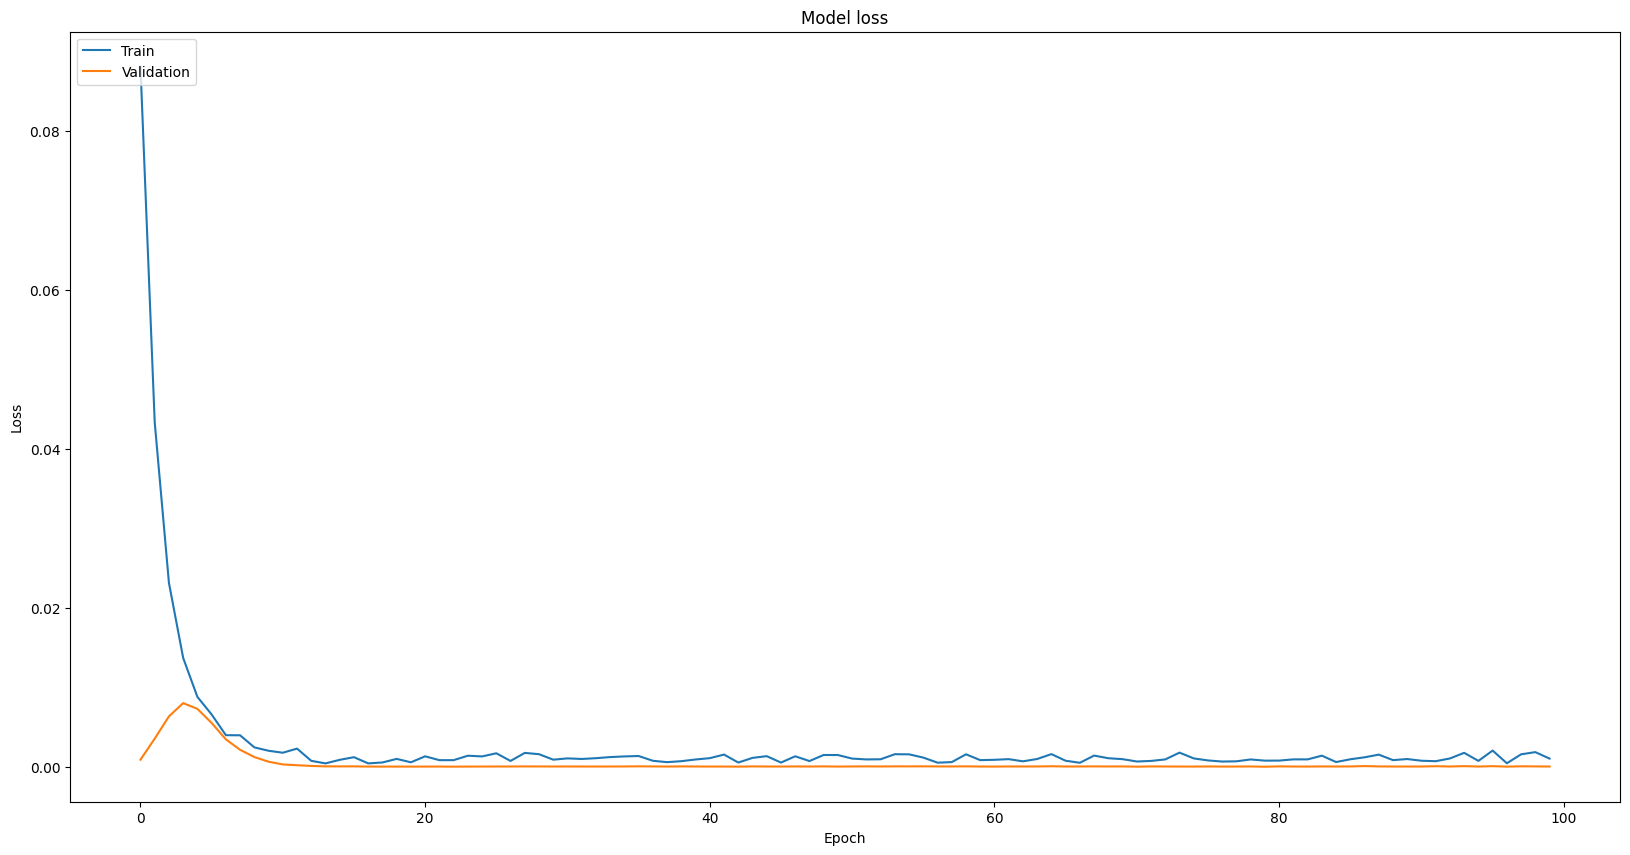

In [208]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

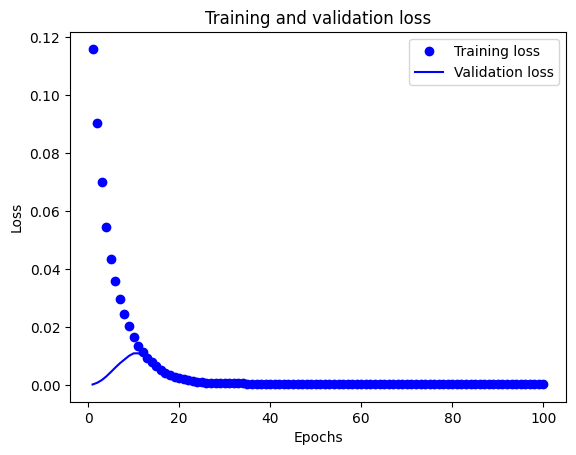

In [163]:
import matplotlib.pyplot as plt

# 학습과 검증 손실 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 그래프 그리기
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Result Plotting

In [164]:
# predicted = model.predict(validation_datas)
# predicted_inverted = []

In [165]:
# for i in range(original_datas.shape[1]):
# 	scaler.fit((np.char.replace((original_datas[:,i].astype(str)), ',', '').astype(float)).reshape(-1,1))
# 	predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))

In [166]:
# ground_true = ground_true[:,:,0].reshape(-1)
# output_times = output_times.reshape(-1)

# predicted_inverted = np.array(predicted_inverted)[:,:,0].reshape(-1)

In [167]:
# from datetime import datetime
# output_times_datetime = [datetime.strptime(ts.decode(), '%b %d, %Y') for ts in output_times]
# # 변환된 값 확인
# print(output_times_datetime)

In [168]:
# ground_true = np.array([float(y.decode().replace(',', '')) for y in ground_true])
# ground_true

In [234]:
with h5py.File(''.join(['bitcoin2012to2023_close.h5']), 'r') as hf:
    datas = hf['inputs'][()]
    labels = hf['outputs'][()]
    input_times = hf['input_times'][()]
    output_times = hf['output_times'][()]
    original_inputs = hf['original_inputs'][()]
    original_outputs = hf['original_outputs'][()]
    original_datas = hf['original_datas'][()]

scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]

model = Sequential()

#build model
model.add(Conv1D(activation="relu", input_shape=(step_size, nb_features), strides=2	, filters=8, kernel_size=8))
# model.add(Dropout(0.05))
model.add(Conv1D( strides=2, padding="same", filters=nb_features, kernel_size=4))
# 가중치 적용: weights에 생성된 적절한 가중치 선택
model.load_weights('weights_2012to2023/2012to2023_BTC-USD-10-0.00069.hdf5')
model.compile(loss='mse', optimizer='adam')

In [235]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit((np.char.replace((original_datas[:,i].astype(str)), ',', '').astype(float)).reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,:,i]))
print(np.array(predicted_inverted).shape)
#get only the close data
ground_true = ground_true.reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times.astype(str), format="%b %d, %Y")
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print(np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.astype(str).reshape(-1), format="%b %d, %Y")

(1, 90, 1)
(90,)


D:\works\time-series-da\venv\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [236]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true

In [237]:
ground_true_df

,times,value
0,2014-07-03,b'638.0'
1,2014-07-02,b'645.7'
2,2014-07-01,b'643.2'
3,2014-06-30,b'635.1'
4,2014-06-29,b'601.1'
...,...,...
805,2012-04-19,b'5.1'
806,2012-04-18,b'5.1'
807,2012-04-17,b'5.0'
808,2012-04-16,b'4.9'


In [238]:
ground_true_df['value'] = ground_true_df['value'].apply(lambda x: float(x.decode('utf-8').replace(",", "")))

In [239]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df

,times,value
0,2014-06-25,2312.260010
1,2014-06-16,2296.868652
2,2014-06-07,2320.436523
3,2014-05-29,2337.582031
4,2014-05-20,2241.723633
...,...,...
85,2012-05-21,1819.656128
86,2012-05-12,1819.593506
87,2012-05-03,1819.601929
88,2012-04-24,1819.615967


In [240]:
# prediction_df['value'] = prediction_df['value'].apply(lambda x: float(x.decode('utf-8').replace(",", "")))

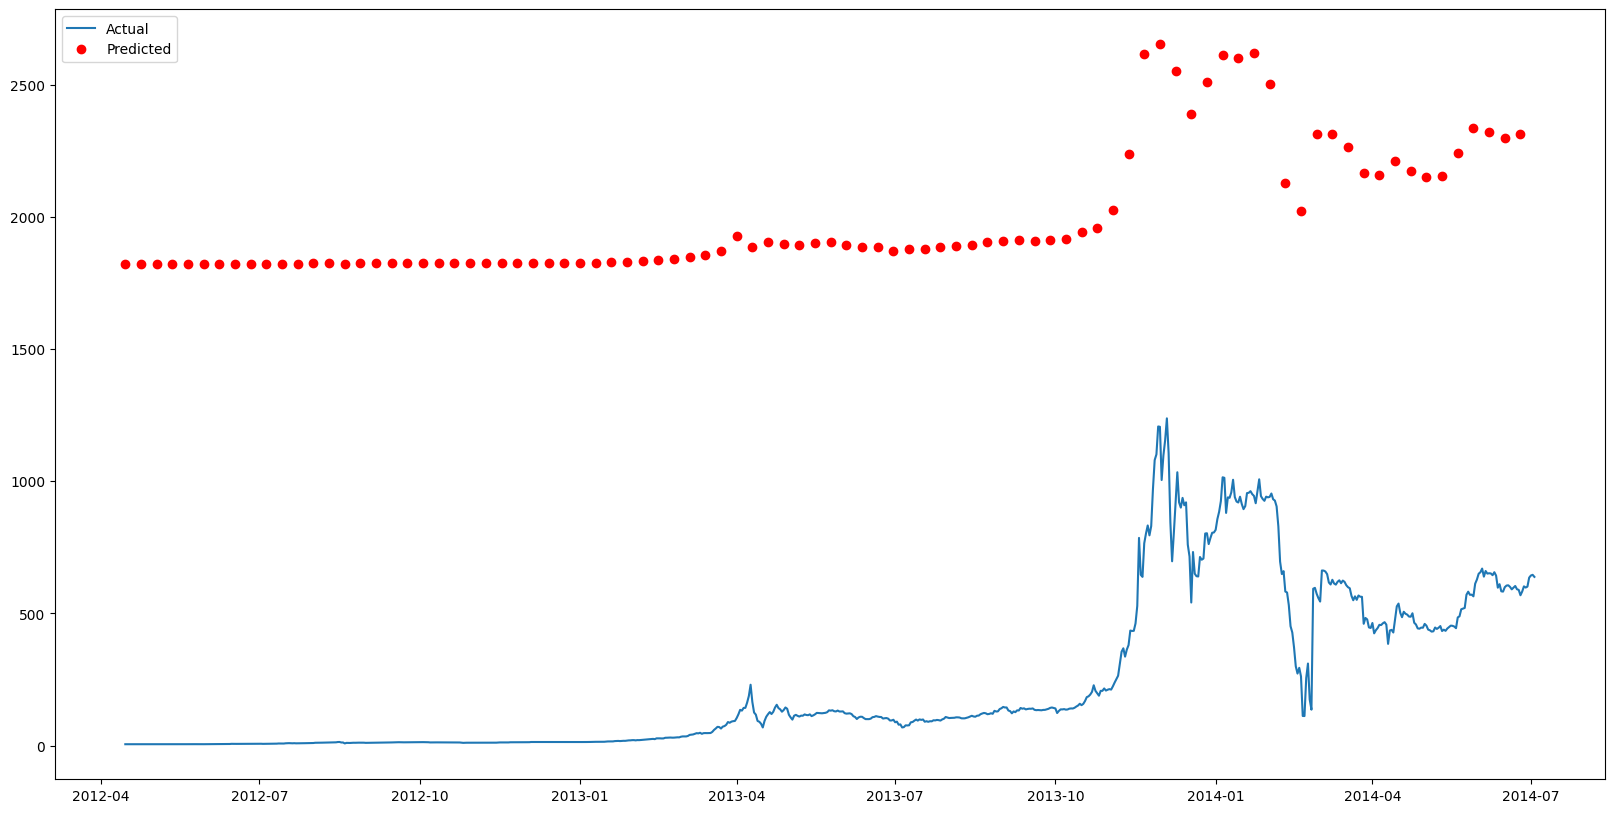

In [241]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.show()

In [221]:
# #TODO: 일단 전체(original) 데이터 출력해보기
# plt.figure(figsize=(20,10))
# plt.plot(all_times, np.char.replace((all_original_values.astype(str)), ',', '').astype(float))
# plt.show()

In [222]:
# #TODO: 전체 데이터와 학습데이터 함께 출력해보기
# # Plot original data
# plt.plot(original_df.index, original_df['Price'], label='Ground Truth')

# # Plot validation data
# plt.plot(validation_output_times, predicted_inverted, label='Validation Prediction')

# # Plot training data
# train_output_times = pd.to_datetime(train_output_times.astype(str).reshape(-1), format="%b %d, %Y")
# train_output = model.predict(train_datas)
# train_predicted_inverted = []
# for i in range(original_datas.shape[1]):
#     scaler.fit((np.char.replace((original_datas[:,i].astype(str)), ',', '').astype(float)).reshape(-1,1))
#     train_predicted_inverted.append(scaler.inverse_transform(train_predicted[:,:,i]))
# train_predicted_inverted = np.array(train_predicted_inverted)[0,:,:].reshape(-1)
# plt.plot(train_output_times, train_predicted_inverted, label='Training Prediction')

# plt.legend()
# plt.show()

In [ ]:
# 1. df 내 값들을 하루에 하나로 resample
%matplotlib inline
prediction_df.set_index('times', inplace=True)
ground_true_df.set_index('times', inplace=True)

# prediction_df.index = pd.to_datetime(prediction_df.index)
# ground_true_df.index = pd.to_datetime(ground_true_df.index)

prediction_df = prediction_df.resample('D').last()
ground_true_df = ground_true_df.resample('D').last()

plt.figure(figsize=(20,10))
plt.plot(ground_true_df.index,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.index,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
# plt.savefig('result_2018to2023/bitcoin2018to2023_close_CNN_2_relu_result.png')
plt.show()

In [ ]:
# 2. df 내 모든 값 표시
prediction_df = prediction_df.loc[(prediction_df["times"] >= "2012-05-15") ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"] >= "2012-05-15")]

plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
# plt.savefig('result_2018to2023/bitcoin2018to2023_close_CNN_2_relu_result.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

In [ ]:
# 그래프 출력
# plt.figure(figsize=(20,10))
# plt.plot(all_times, all_original_values, label='Actual')
# plt.legend(loc='upper left')
# plt.show()

In [ ]:
output_times